## ECG Exploratory Data Analysis

First, I noticed that in ECG data folder, each patient folder contains different number of files. Typically with baches of 3 files:
- `.dat` - Raw ECG signal data
- `.hea` - Header file (metadata: age, sex, diagnose, hemodynamics, therapy, etc.)
- `.xyz` - Likely 3D vectorcardiogram (VCG) data

There are 294 patients, but not separated into train and test sets, like in the MRI folder.

After a short inspection, each folder seems to contain either 3 files, 6 files, or another number of files that is a multiple of 3. Let's first check the number of files per patient.

In [ ]:
import os
from collections import defaultdict

ecg_dir = "../data/ECG/"
patient_file_counts = defaultdict(int)

for patient in sorted(os.listdir(ecg_dir)):
    patient_folder = os.path.join(ecg_dir, patient)
    if os.path.isdir(patient_folder):
        patient_file_counts[patient] = len(os.listdir(patient_folder))

for patient, count in patient_file_counts.items():
    print(f"{patient}: {count} files")

patient001: 9 files
patient002: 3 files
patient003: 3 files
patient004: 6 files
patient005: 15 files
patient006: 9 files
patient007: 12 files
patient008: 9 files
patient009: 3 files
patient010: 9 files
patient011: 12 files
patient012: 6 files
patient013: 9 files
patient014: 9 files
patient015: 9 files
patient016: 9 files
patient017: 12 files
patient018: 9 files
patient019: 9 files
patient020: 9 files
patient021: 9 files
patient022: 9 files
patient023: 12 files
patient024: 12 files
patient025: 9 files
patient026: 6 files
patient027: 9 files
patient028: 9 files
patient029: 9 files
patient030: 12 files
patient031: 12 files
patient032: 12 files
patient033: 12 files
patient034: 12 files
patient035: 12 files
patient036: 9 files
patient037: 6 files
patient038: 9 files
patient039: 9 files
patient040: 12 files
patient041: 12 files
patient042: 12 files
patient043: 9 files
patient044: 12 files
patient045: 12 files
patient046: 12 files
patient047: 9 files
patient048: 12 files
patient049: 12 files


It seems some patients have more files because they have been checked multiple times. So, we may have more data about some patients and some diseases that others. This might cause class imbalance, and we should address that later as well.

Now, let's see what data each type of file contains. Starting with a sample `.hea` file, which contains metadata about the patient.

In [1]:
hea_path = "../data/ECG/patient001/s0010_re.hea"

with open(hea_path, "r") as f:
    header_data = f.readlines()

for line in header_data:
    print(line.strip())

s0010_re 15 1000 38400
s0010_re.dat 16 2000 16 0 -489 -8337 0 i
s0010_re.dat 16 2000 16 0 -458 -16369 0 ii
s0010_re.dat 16 2000 16 0 31 6829 0 iii
s0010_re.dat 16 2000 16 0 474 4582 0 avr
s0010_re.dat 16 2000 16 0 -260 11687 0 avl
s0010_re.dat 16 2000 16 0 -214 -16657 0 avf
s0010_re.dat 16 2000 16 0 -88 -12469 0 v1
s0010_re.dat 16 2000 16 0 -241 5636 0 v2
s0010_re.dat 16 2000 16 0 -112 -14299 0 v3
s0010_re.dat 16 2000 16 0 212 -17916 0 v4
s0010_re.dat 16 2000 16 0 393 -6668 0 v5
s0010_re.dat 16 2000 16 0 390 -17545 0 v6
s0010_re.xyz 16 2000 16 0 -3 -13009 0 vx
s0010_re.xyz 16 2000 16 0 120 7109 0 vy
s0010_re.xyz 16 2000 16 0 -18 -1992 0 vz

# age: 81
# sex: female
# ECG date: 01/10/1990

# Diagnose:
# Reason for admission: Myocardial infarction
# Acute infarction (localization): infero-latera
# Former infarction (localization): no
# Additional diagnoses: Diabetes mellitus
# Smoker: no
# Number of coronary vessels involved: 1
# Infarction date (acute): 29-Sep-90
# Previous infarction (1

Next, visualizing ECG signals.

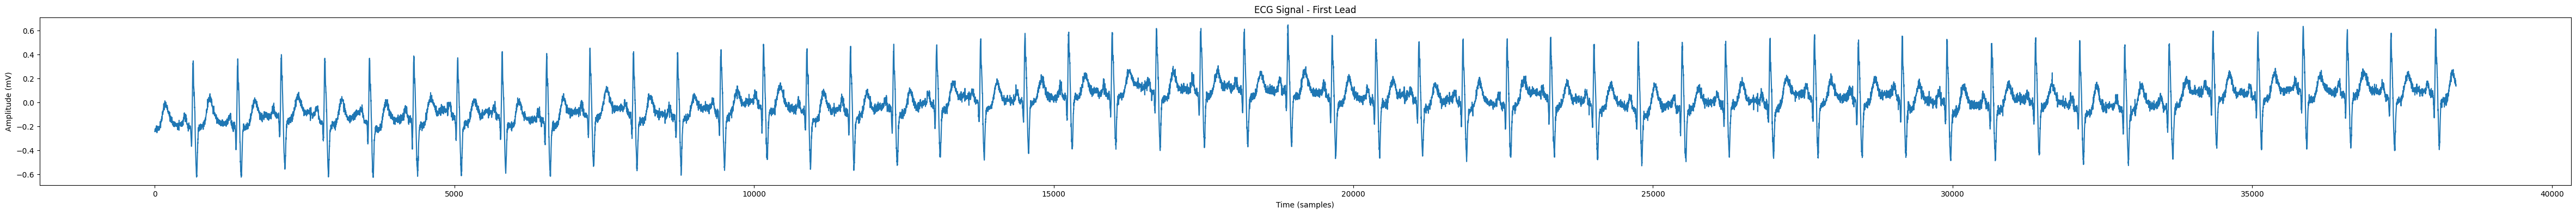

In [2]:
import wfdb
import matplotlib.pyplot as plt

record_name = "../data/ECG/patient001/s0010_re"
record = wfdb.rdrecord(record_name)

# Plot the first lead
plt.figure(figsize=(60, 4))
plt.plot(record.p_signal[:, 0])
plt.title("ECG Signal - First Lead")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.show()

Let's see a part of this sequence to see the details better (P wave, T wave, QRS complex).

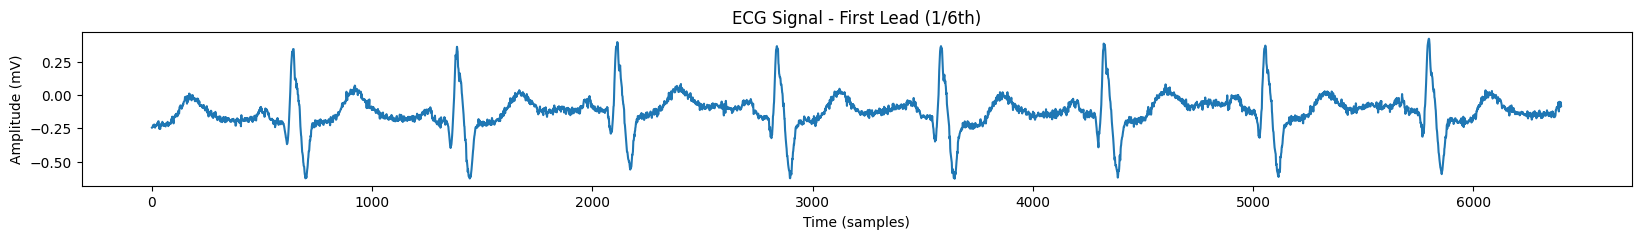

In [3]:
plt.figure(figsize=(20, 2))
plt.plot(record.p_signal[:len(record.p_signal) // 6, 0])
plt.title("ECG Signal - First Lead (1/6th)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.show()

However, this is only the first lead of the 15-lead ECG. The typical 12-lead ECG is typically divided into:
- 3 Standard Limb Leads (I, II, III)
- 3 Augmented Limb Leads (aVR, aVL, aVF)
- 6 Precordial (Chest) Leads (V1, V2, V3, V4, V5, V6)

But this dataset contains 15-lead ECGs, which includes also 3 Frank XYZ leads.
- X-axis (left-to-right): Measures electrical activity along the horizontal plane.
- Y-axis (up-to-down): Measures electrical activity along the frontal plane.
- Z-axis (front-to-back): Measures electrical activity along the sagittal plane.

The whole ECG of this one patient looks like this:

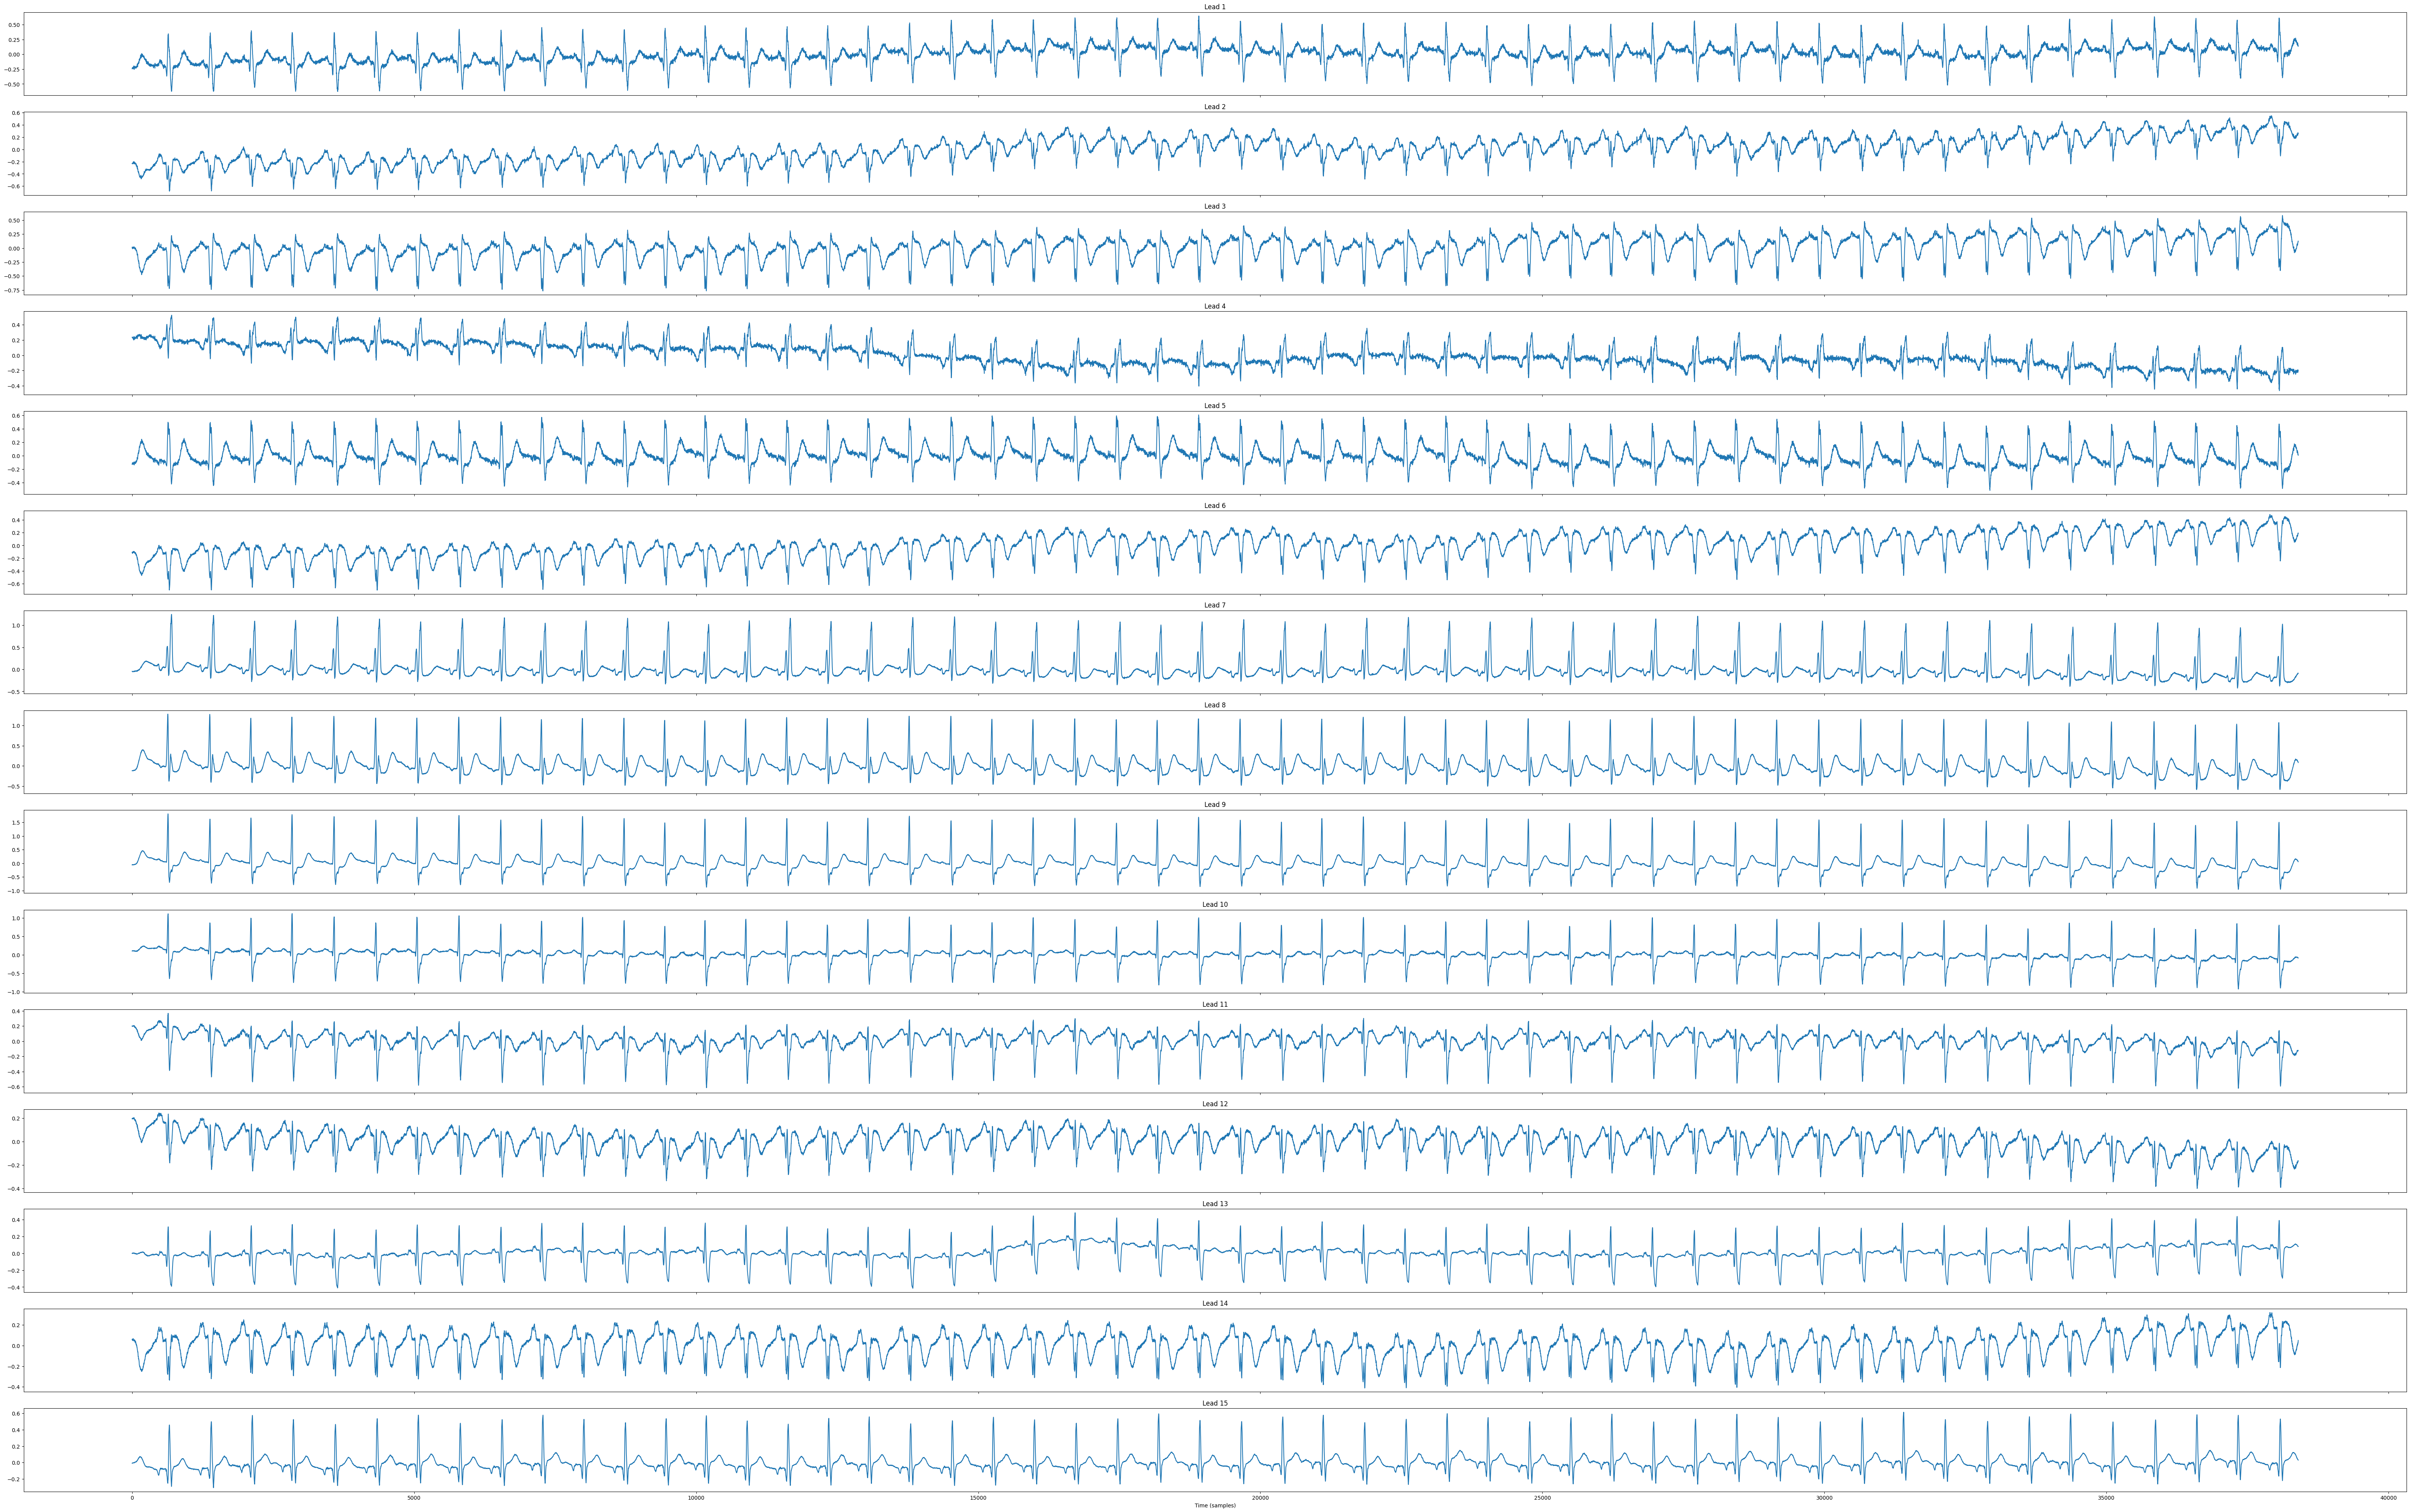

In [4]:
fig, axes = plt.subplots(record.n_sig, 1, figsize=(80, 50), sharex=True)

for i in range(record.n_sig):
    axes[i].plot(record.p_signal[:, i])
    axes[i].set_title(f"Lead {i+1}")

plt.xlabel("Time (samples)")
plt.show()

Visually, all the leads contain the expected waveforms (P, QRS, T waves). There are no missing leads or flat lines, which is good.

In [5]:
import numpy as np

missing_values = np.isnan(record.p_signal).sum()
print(f"Missing data points: {missing_values}")

Missing data points: 0


There are no null values in the signal, which is great, and no imputation is needed.

Let's look at overall metadata information about the patients. First, we need to traverse through the `.hea` files and extract the information, then convert it to a dataframe.

In [7]:
import re
import os
import pandas as pd

ecg_dir = "../data/ECG/"
patients_metadata = []

for patient in sorted(os.listdir(ecg_dir)):
    patient_folder = os.path.join(ecg_dir, patient)
    
    if os.path.isdir(patient_folder):
        for file in os.listdir(patient_folder):
            if file.endswith(".hea"):
                hea_path = os.path.join(patient_folder, file)
                
                with open(hea_path, "r") as f:
                    lines = f.readlines()
                
                patient_data = {"Patient ID": patient, "File": file}
                first_line = lines[0].strip().split()
                patient_data["Sampling Rate"] = int(first_line[2]) if len(first_line) > 2 else None
                
                for line in lines:
                    if "age:" in line.lower():
                        match = re.search(r"\d+", line)
                        patient_data["Age"] = int(match.group()) if match else None
                    elif "sex:" in line.lower():
                        patient_data["Sex"] = line.split(":")[-1].strip()
                    elif "Reason for admission:" in line:
                        patient_data["Diagnosis"] = line.split(":")[-1].strip()
                
                patients_metadata.append(patient_data)

df_metadata = pd.DataFrame(patients_metadata)

print(df_metadata.head())

   Patient ID          File  Sampling Rate   Age     Sex  \
0  patient001  s0010_re.hea           1000  81.0  female   
1  patient001  s0014lre.hea           1000  81.0  female   
2  patient001  s0016lre.hea           1000  81.0  female   
3  patient002  s0015lre.hea           1000  58.0  female   
4  patient003  s0017lre.hea           1000  63.0    male   

               Diagnosis  
0  Myocardial infarction  
1  Myocardial infarction  
2  Myocardial infarction  
3  Myocardial infarction  
4  Myocardial infarction  


In [8]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient ID     549 non-null    object 
 1   File           549 non-null    object 
 2   Sampling Rate  549 non-null    int64  
 3   Age            531 non-null    float64
 4   Sex            549 non-null    object 
 5   Diagnosis      549 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 25.9+ KB


Only the Age attribute has missing values (18 nulls), we can either impute it or label the missingness in the data processing step.

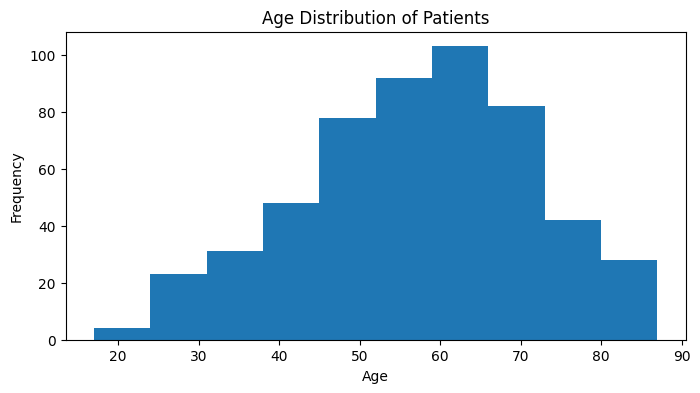

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df_metadata["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Patients")
plt.show()

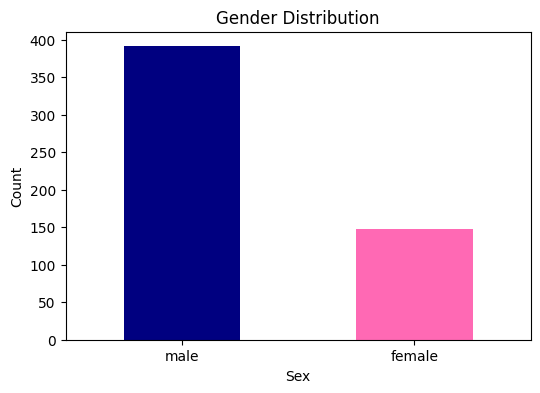

In [ ]:
plt.figure(figsize=(6, 4))
df_metadata[df_metadata["Sex"].isin(["male", "female"])]["Sex"].value_counts().plot(kind="bar", color=["navy", "hotpink"])
plt.title("Gender Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

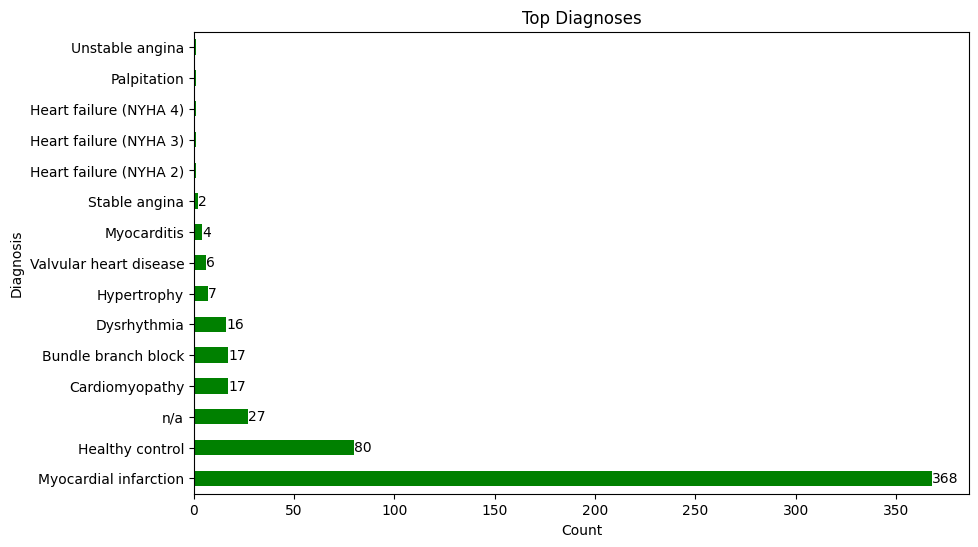

In [ ]:
plt.figure(figsize=(10, 6))
ax = df_metadata["Diagnosis"].value_counts().plot(kind="barh", color="green")
for index, value in enumerate(df_metadata["Diagnosis"].value_counts().head(10)):
    ax.text(value, index, str(value), va='center', ha='left', color='black')
plt.xlabel("Count")
plt.title("Top Diagnoses")
plt.show()

We already visualizes the `.dat` files, which provide the ECG signlas. Now let's look at `.xyz` files, which contains VCG signals and see if they provide additional information. 

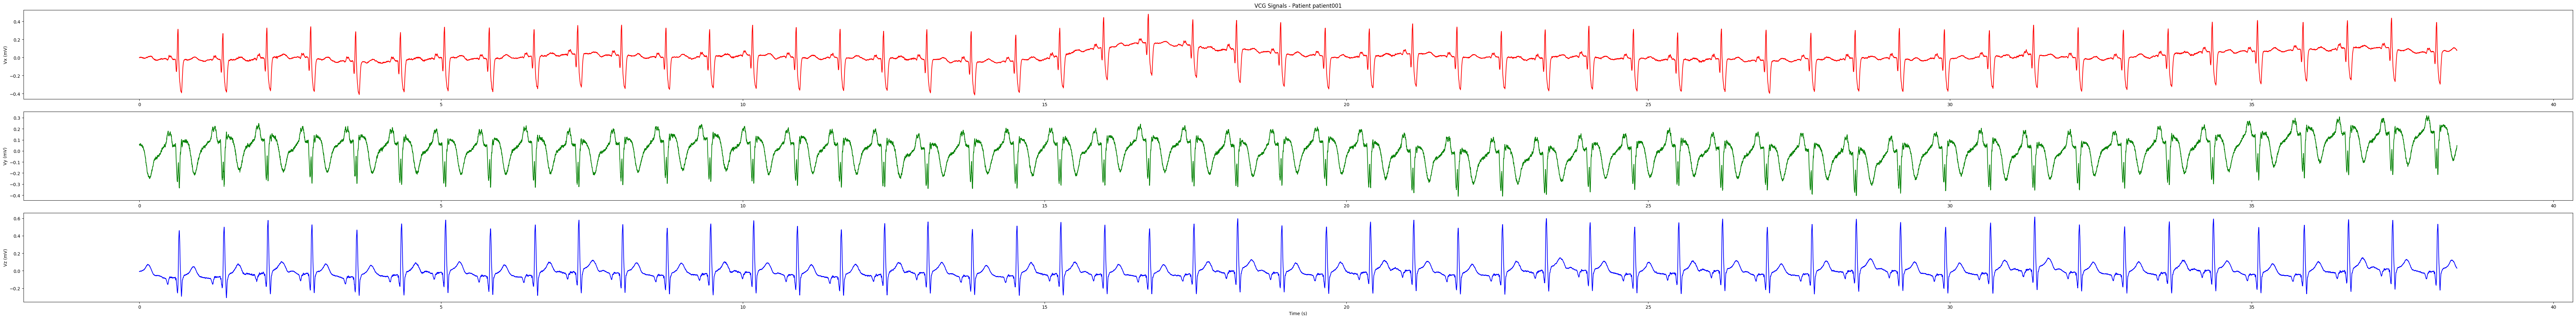

In [ ]:
patient_id = "patient001"
ecg_dir = "../data/ECG/"
record_name = "s0010_re"

record_path = os.path.join(ecg_dir, patient_id, record_name)
signals, fields = wfdb.rdsamp(record_path)
vx, vy, vz = signals[:, -3], signals[:, -2], signals[:, -1]
fs = fields["fs"]

plt.figure(figsize=(80, 10))
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(vx)) / fs, vx, color="r")
plt.title(f"VCG Signals - Patient {patient_id}")
plt.ylabel("Vx (mV)")

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(vy)) / fs, vy, color="g")
plt.ylabel("Vy (mV)")

plt.subplot(3, 1, 3)
plt.plot(np.arange(len(vz)) / fs, vz, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Vz (mV)")

plt.tight_layout()
plt.show()

If we look closely, these are the same last 3 leads of 15-lead ECG signals that we visualized from `.dat` files, so I think we can ignore the `.xyz` files during the workflow.

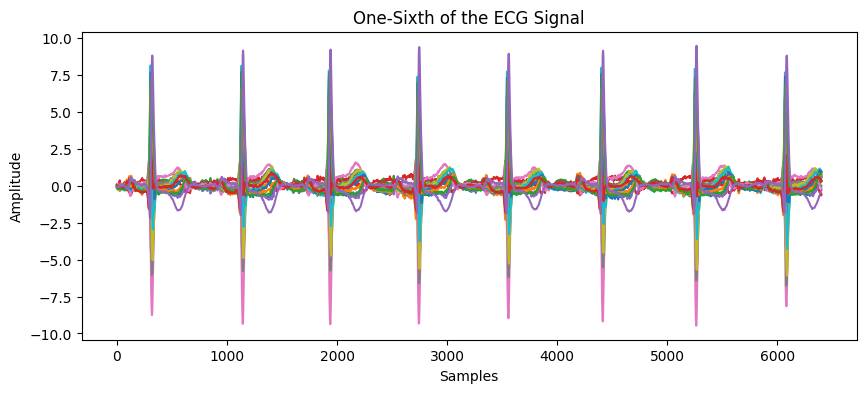

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Use one of the corrected file paths (e.g., raw string or forward slashes)
file_path = r"C:\Users\Dell\Desktop\multimodal-cardiac-diagnosis\processed_data\ECG\s0001_re.npy"

# Load the ECG signal
ecg_signal = np.load(file_path)

# Check the length of the signal
signal_length = len(ecg_signal)

# Calculate the index for one-sixth of the signal
one_sixth_length = signal_length // 6

# Slice the signal to get the first one-sixth
ecg_signal_one_sixth = ecg_signal[:one_sixth_length]

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_signal_one_sixth)
plt.title("One-Sixth of the ECG Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


Text(0, 0.5, 'Amplitude')

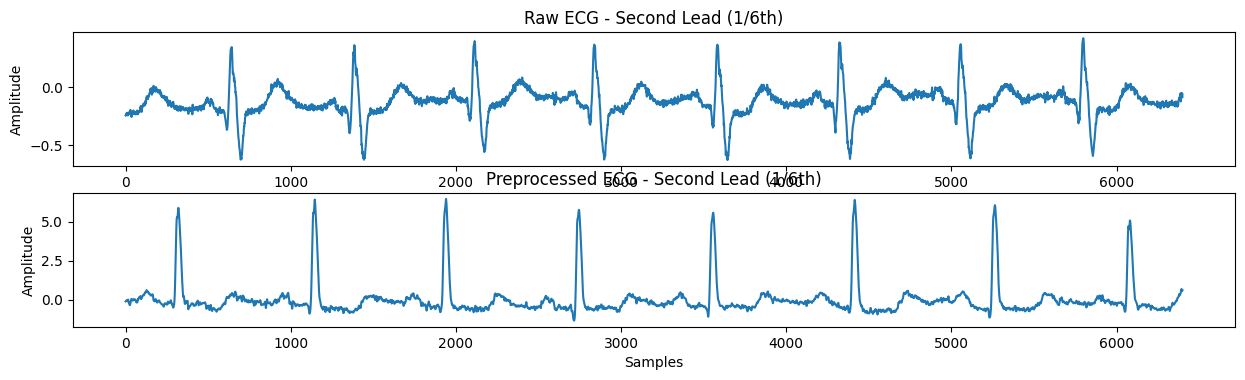

In [49]:
preprocessed_file_path = r"C:\Users\Dell\Desktop\multimodal-cardiac-diagnosis\processed_data\ECG\s0001_re.npy"
preprocessed_ecg = np.load(preprocessed_file_path)
raw_ecg_file_path = r"C:\Users\Dell\Desktop\multimodal-cardiac-diagnosis\data\ECG\patient001\s0010_re.dat"
record = wfdb.rdrecord(raw_ecg_file_path.replace('.dat', ''))

raw_ecg_lead_1 = record.p_signal[:, 0]
preprocessed_lead_1 = preprocessed_ecg[:, 0]
signal_length = len(raw_ecg_lead_1)
one_sixth_length = signal_length // 6
raw_ecg_lead_1_slice = raw_ecg_lead_1[:one_sixth_length]
preprocessed_lead_1_slice = preprocessed_lead_1[:one_sixth_length]

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(raw_ecg_lead_1_slice)
plt.title("Raw ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
plt.plot(preprocessed_lead_1_slice)
plt.title("Preprocessed ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

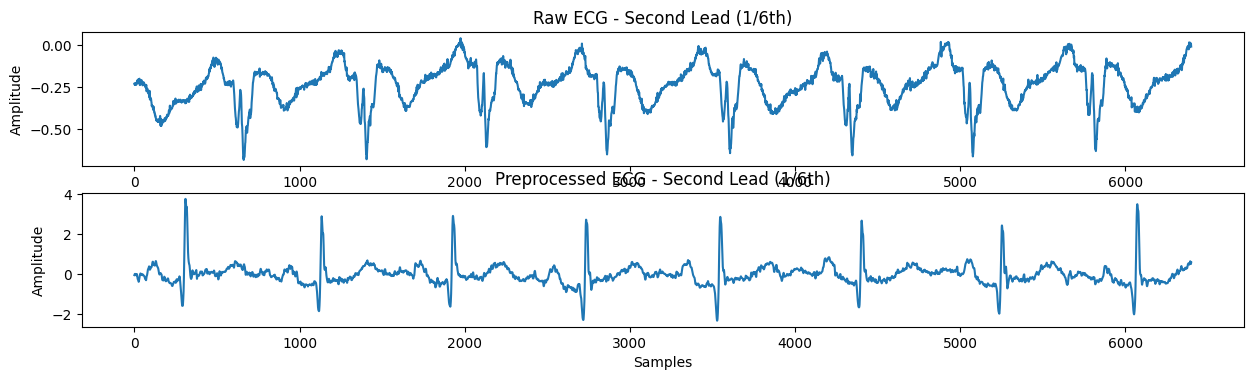

In [51]:
raw_ecg_lead_2 = record.p_signal[:, 1]
preprocessed_lead_2 = preprocessed_ecg[:, 1]
signal_length = len(raw_ecg_lead_2)
one_sixth_length = signal_length // 6
raw_ecg_lead_2_slice = raw_ecg_lead_2[:one_sixth_length]
preprocessed_lead_2_slice = preprocessed_lead_2[:one_sixth_length]

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(raw_ecg_lead_2_slice)
plt.title("Raw ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
plt.plot(preprocessed_lead_2_slice)
plt.title("Preprocessed ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

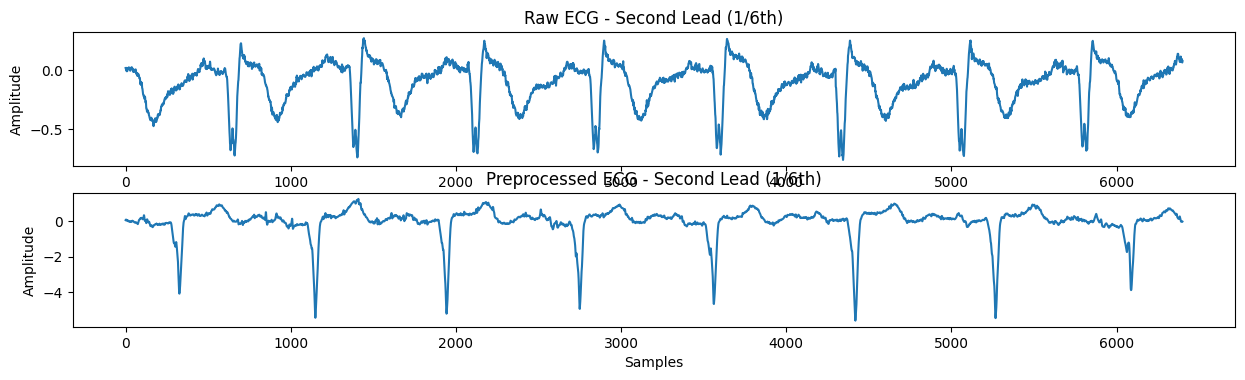

In [52]:
raw_ecg_lead_3 = record.p_signal[:, 2]
preprocessed_lead_3 = preprocessed_ecg[:, 2]
signal_length = len(raw_ecg_lead_3)
one_sixth_length = signal_length // 6
raw_ecg_lead_3_slice = raw_ecg_lead_3[:one_sixth_length]
preprocessed_lead_3_slice = preprocessed_lead_3[:one_sixth_length]

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(raw_ecg_lead_3_slice)
plt.title("Raw ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
plt.plot(preprocessed_lead_3_slice)
plt.title("Preprocessed ECG - Second Lead (1/6th)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")